<a href="https://colab.research.google.com/github/ZnattapolZ/Enhancing-The-Visualization-of-Latent-Fingerprint/blob/main/%5BGAE%5D%20-%20Training%20and%20Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Checking Type of Graphic Card**

In [ ]:
!nvidia-smi

Mon Apr  5 09:37:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    22W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Import libraries**

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import datetime
import math
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import natsort
pd.options.display.max_colwidth = 100

from keras.layers import *
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from keras.utils.vis_utils import plot_model
from random import *

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Preparing Dataset**
> To use These sections below, please connect to Google Drive frist

In [ ]:
TRAIN_PATH = '/content/drive/MyDrive/data_samples/synth_data/train_noise/preprocessed/'
TRAIN_TARGET_PATH = '/content/drive/MyDrive/data_samples/synth_data/train_ground/preprocessed/'

## **Prepare dataframe for training model**

In [ ]:
# Get image paths from the directory
train_path_list = [f for f in glob.glob(TRAIN_PATH + '*.png')]
train_path_list.sort()

train_target_path_list = [f for f in glob.glob(TRAIN_TARGET_PATH + '*.png')]
train_target_path_list.sort()

print('train path lenght:', len(train_path_list))
print('train target path lenght', len(train_target_path_list))

train_dataframe = {
  'train': train_path_list,
  'train_target': train_target_path_list
}

train_df = pd.DataFrame(data = train_dataframe)
print(train_df)

train path lenght: 8000
train target path lenght 8000
                                                                                 train                                                                       train_target
0        /content/drive/MyDrive/data_samples/synth_data/train_noise/preprocessed/1.png     /content/drive/MyDrive/data_samples/synth_data/train_ground/preprocessed/1.png
1       /content/drive/MyDrive/data_samples/synth_data/train_noise/preprocessed/10.png    /content/drive/MyDrive/data_samples/synth_data/train_ground/preprocessed/10.png
2      /content/drive/MyDrive/data_samples/synth_data/train_noise/preprocessed/100.png   /content/drive/MyDrive/data_samples/synth_data/train_ground/preprocessed/100.png
3     /content/drive/MyDrive/data_samples/synth_data/train_noise/preprocessed/1000.png  /content/drive/MyDrive/data_samples/synth_data/train_ground/preprocessed/1000.png
4     /content/drive/MyDrive/data_samples/synth_data/train_noise/preprocessed/1001.png  /content

In [ ]:
print(os.path.splitext(train_path_list[0].split('/')[-1].split('.')[0])[0])

1


In [ ]:
count = 1
for path in train_target_path_list:
  num_img = path.split('/')[-1].split('.')[0]
  if count != num_img:
    print(num_img)
  count = count + 1

## **Prepare dataframe for model evaluation**

In [ ]:
TEST_PATH = '/content/drive/MyDrive/data_samples/synth_data/test_noise/preprocessed/'
TEST_TARGET_PATH = '/content/drive/MyDrive/data_samples/synth_data/test_ground/preprocessed/'

In [ ]:
test_path_list = [f for f in glob.glob(TEST_PATH + '*.png')]
test_path_list.sort()

test_target_path_list = [f for f in glob.glob(TEST_TARGET_PATH + '*.png')]
test_target_path_list.sort()

test_dataframe = {
  'test': test_path_list,
  'test_target': test_target_path_list
}

test_df = pd.DataFrame(data = test_dataframe)
print(test_df.head())

                                                                               test                                                                        test_target
0  /content/drive/MyDrive/data_samples/synth_data/test_noise/preprocessed/10000.png  /content/drive/MyDrive/data_samples/synth_data/test_ground/preprocessed/10000.png
1   /content/drive/MyDrive/data_samples/synth_data/test_noise/preprocessed/8001.png   /content/drive/MyDrive/data_samples/synth_data/test_ground/preprocessed/8001.png
2   /content/drive/MyDrive/data_samples/synth_data/test_noise/preprocessed/8002.png   /content/drive/MyDrive/data_samples/synth_data/test_ground/preprocessed/8002.png
3   /content/drive/MyDrive/data_samples/synth_data/test_noise/preprocessed/8003.png   /content/drive/MyDrive/data_samples/synth_data/test_ground/preprocessed/8003.png
4   /content/drive/MyDrive/data_samples/synth_data/test_noise/preprocessed/8004.png   /content/drive/MyDrive/data_samples/synth_data/test_ground/preprocessed/8004.pn

## **Check whether train and train_target is the same**

In [ ]:
count = 0
for row in range(len(train_df)):
  data = train_df.loc[row]
  x = data.train.split('/')
  y = data.train_target.split('/')
  if (x[-1] != y[-1]):
    print('found err! x != y : ', x, y)
  else: count = count + 1

print('Test every data have correct target: ', count == len(train_df))

Test every data have correct target:  True


## **Fetch Image by Batch**


In [ ]:
def get_image_batch(paths, dim=(256, 320), thresholding=False):
  image_list = []
  for path in paths:
    img = cv2.imread(path, 0)
    resized_img = cv2.resize(img, dim, interpolation = cv2.INTER_NEAREST)
    if thresholding:
      _, binarized_img = cv2.threshold(resized_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      image_list.append(binarized_img / 255.0)
    else:
      image_list.append(resized_img / 255.0)

  return image_list

In [ ]:
# Unit Test
t_batch_size = 10
t_batch_start = 20
t_batch_end = 29
target_dim = (256,320) # width, height

t_x_batch = train_df.train[t_batch_start: t_batch_end + 1]
t_x_train = get_image_batch(t_x_batch, target_dim, True)
t_x_train2 = get_image_batch(t_x_batch, target_dim, False)

print('test num_image eq to batch_size:', len(t_x_train) == t_batch_size)
print('test return type is list of image:', isinstance(t_x_train, list) and isinstance(t_x_train[5], np.ndarray))
print('test returned image size eq to target size:', (target_dim[1], target_dim[0]) == t_x_train[5].shape)

test num_image eq to batch_size: True
test return type is list of image: True
test returned image size eq to target size: True


In [ ]:
len(t_x_train)

10

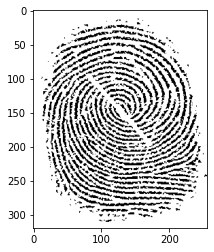

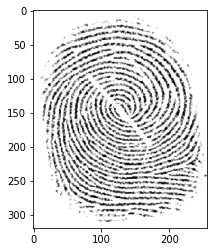

In [ ]:
plt.imshow(t_x_train[5],'gray'), plt.show()
plt.imshow(t_x_train2[5],'gray')

# **Experimental Parameters**

## Experimental ID

In [ ]:
EXPERIMENTAL_ID = 6

## Model and Process Parameters

In [ ]:
INPUT_SHAPE = (320, 256, 1)  # height, width, ch

E_LAYER_SIZES = [256, 128, 64, 32, 16, 8]
E_FILTER_SIZES = [13, 11, 9, 7, 5, 5]
E_NUM_FILTERS = [1, 128, 256, 256, 512, 1024]

G_LAYER_SIZES = [16, 32, 64, 128, 256]
G_FILTER_SIZES = [7, 9, 11, 13, 5]
G_NUM_FILTERS = [1024, 512, 256, 256, 128]

In [ ]:
GAUSS_BLOCK_KERNEL_SIZE = 7
GAUSS_BLOCK_SIGMA = 1
GAUSS_ORIENT_KERNEL_SIZE = 31
GAUSS_ORIENT_SIGMA = 5

In [ ]:
GRAD_WEIGHT = 1
ORI_WEIGHT = 1.5
REL_WEIGHT = 1

GRAD_LOSS_SCALE = 10
ORI_LOSS_SCALE = 1e-1
REL_LOSS_SCALE = 1e-6

MAGIC_NUMBER_REL = 0.001

## Hyper Parameters

In [ ]:
WEIGHT_DECAY = 1e-4     
MOMENTUM     = 0.5        
LR           = 0.0002      # initial learning rate
EPSILON      = 1e-8

In [ ]:
BATCH_SIZE = 20
EPOCH      = 21

# **Define Auto-Encoder**

In [ ]:
def define_autoencoder(input_shape,
                       e_layer_sizes, 
                       e_filter_sizes, 
                       e_num_filters,
                       g_layer_sizes,
                       g_filter_sizes,
                       g_num_filters):
    
  e_iterations = len(e_layer_sizes)
  g_iterations = len(g_layer_sizes)

  # Encoder Section
  input_layer = Input(shape = input_shape)
  for i in range(e_iterations):
    if (i != 0):
        x = Conv2D(e_num_filters[i], kernel_size=(e_filter_sizes[i], e_filter_sizes[i]), strides=(2,2), padding='same')(x)
    else:
        x = Conv2D(e_num_filters[i], kernel_size=(e_filter_sizes[i], e_filter_sizes[i]), strides=(1,1), padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

  
  # Ganerative Section
  for i in range(g_iterations):
    x = Conv2DTranspose(filters = g_num_filters[i], 
                        kernel_size = (g_filter_sizes[i], g_filter_sizes[i]), 
                        strides = (2, 2), 
                        padding = 'same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
  
  x = Conv2DTranspose(1, kernel_size=(1, 1), padding='same')(x)
  output_layer = tf.keras.activations.sigmoid(x)

  model = Model(input_layer, output_layer)
  
  return model

In [ ]:
model = define_autoencoder(input_shape = INPUT_SHAPE,
                          e_layer_sizes = E_LAYER_SIZES,
                          e_filter_sizes = E_FILTER_SIZES,
                          e_num_filters = E_NUM_FILTERS,
                          g_layer_sizes = G_LAYER_SIZES,
                          g_filter_sizes = G_FILTER_SIZES,
                          g_num_filters = G_NUM_FILTERS)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 320, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 320, 256, 1)       170       
_________________________________________________________________
batch_normalization (BatchNo (None, 320, 256, 1)       4         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 320, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 160, 128, 128)     15616     
_________________________________________________________________
batch_normalization_1 (Batch (None, 160, 128, 128)     512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 160, 128, 128)     0     

## Check memory usage

In [ ]:
# https://stackoverflow.com/questions/43137288/how-to-determine-needed-memory-of-keras-model/45242364
def get_model_memory_usage(batch_size, model):
  import numpy as np
  try:
    from keras import backend as K
  except:
    from tensorflow.keras import backend as K

  shapes_mem_count = 0
  internal_model_mem_count = 0
  for l in model.layers:
    layer_type = l.__class__.__name__
    if layer_type == 'Model':
        internal_model_mem_count += get_model_memory_usage(batch_size, l)
    single_layer_mem = 1
    out_shape = l.output_shape
    if type(out_shape) is list:
        out_shape = out_shape[0]
    for s in out_shape:
        if s is None:
            continue
        single_layer_mem *= s
    shapes_mem_count += single_layer_mem

  trainable_count = np.sum([K.count_params(p) for p in model.trainable_weights])
  non_trainable_count = np.sum([K.count_params(p) for p in model.non_trainable_weights])

  number_size = 4.0
  if K.floatx() == 'float16':
    number_size = 2.0
  if K.floatx() == 'float64':
    number_size = 8.0

  total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
  gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
  return gbytes

In [ ]:
memory_used = get_model_memory_usage(batch_size=BATCH_SIZE, model=model)
print(memory_used)

# **Define Loss Functions**

## **Ridge Gradient TF**

In [ ]:
def ridge_gradient_tf(images_tf):
  sobel_0 = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]).reshape(3,3,1,1)
  sobel_45 = np.array([[-1, -1, 0], [-1, 0, 1], [0, 1, 1]]).reshape(3,3,1,1)
  sobel_90 = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]).reshape(3,3,1,1)
  sobel_135 = np.array([[0, -1, -1], [1, 0, -1], [1, 1, 0]]).reshape(3,3,1,1)
  
  images_tf = tf.pad(images_tf, [[0,0], [1,1], [1,1], [0,0]], "REFLECT")  
  grads_0 = tf.nn.conv2d(images_tf, sobel_0, strides=[1, 1, 1, 1], padding='VALID')
  grads_45 = tf.nn.conv2d(images_tf, sobel_45, strides=[1, 1, 1, 1], padding='VALID')
  grads_90 = tf.nn.conv2d(images_tf, sobel_90, strides=[1, 1, 1, 1], padding='VALID')
  grads_135 = tf.nn.conv2d(images_tf, sobel_135, strides=[1, 1, 1, 1], padding='VALID')
  
  return grads_0, grads_45, grads_90, grads_135

In [ ]:
# Unit Test for Ridge Gradient TF
test_x = tf.convert_to_tensor(get_image_batch(train_df.train_target[0:2], thresholding=True))
test_x = tf.reshape(test_x, (-1, 320, 256, 1))
a,b,c,d = ridge_gradient_tf(test_x)

plt.imshow(test_x[0].numpy().reshape(320,256),'gray'), plt.show()
plt.imshow(a[0].numpy().reshape(320,256),'gray'), plt.show()
plt.imshow(b[0].numpy().reshape(320,256),'gray'), plt.show()
plt.imshow(c[0].numpy().reshape(320,256),'gray'), plt.show()
plt.imshow(d[0].numpy().reshape(320,256),'gray'), plt.show()

## **Ridge Orientation TF**

In [ ]:
def gaussian_kernel_smoothing(kernel_len = 21, sigma=3):
  kernel = np.zeros((kernel_len, kernel_len))
  # Dirac delta 
  kernel[kernel_len//2, kernel_len//2] = 1
  # Gaussian blur of dirac delta is the 2D gaussian mask filter
  return cv2.GaussianBlur(kernel, (kernel_len,kernel_len), sigmaX=sigma, sigmaY=sigma)

In [ ]:
def ridge_orientation_tf(images_tf):
    gb_k_size = GAUSS_BLOCK_KERNEL_SIZE
    go_k_size = GAUSS_ORIENT_KERNEL_SIZE
    pad_size = int((go_k_size - 1) / 2)

    # Gauss Block and Gauss Orient have to be smaller than this because of our input img is not as big as theirs
    gauss_block = np.array([gaussian_kernel_smoothing(gb_k_size, GAUSS_BLOCK_SIGMA)], dtype= np.float32)
    gauss_orient = np.array([gaussian_kernel_smoothing(go_k_size, GAUSS_ORIENT_SIGMA)], dtype= np.float32).reshape(go_k_size,go_k_size,1,1)

    sobel_0 = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    sobel_90 = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
    gauss_gradient_x = cv2.filter2D(gauss_block.reshape(gb_k_size,gb_k_size), -1, sobel_0).reshape(gb_k_size,gb_k_size,1,1)
    gauss_gradient_y = cv2.filter2D(gauss_block.reshape(gb_k_size,gb_k_size), -1, sobel_90).reshape(gb_k_size,gb_k_size,1,1)
    
    images_tf = tf.pad(images_tf, [[0, 0], [3,3], [3, 3], [0, 0]], "REFLECT")
    gauss_img_x = tf.nn.conv2d(images_tf, gauss_gradient_x, strides=[1, 1, 1, 1], padding='VALID')
    gauss_img_y = tf.nn.conv2d(images_tf, gauss_gradient_y, strides=[1, 1, 1, 1], padding='VALID')

    gauss_img_xx = tf.math.pow(gauss_img_x, 2)
    gauss_img_xy = tf.math.multiply(gauss_img_x, gauss_img_y)
    gauss_img_yy = tf.math.pow(gauss_img_y, 2)

    gauss_img_xx = tf.pad(gauss_img_xx, [[0, 0], [pad_size,pad_size], [pad_size, pad_size], [0, 0]], "REFLECT")
    gauss_img_xy = tf.pad(gauss_img_xy, [[0, 0], [pad_size,pad_size], [pad_size, pad_size], [0, 0]], "REFLECT")
    gauss_img_yy = tf.pad(gauss_img_yy, [[0, 0], [pad_size,pad_size], [pad_size, pad_size], [0, 0]], "REFLECT")
    
    gauss_img_xx = tf.nn.conv2d(gauss_img_xx, gauss_orient, strides=[1, 1, 1, 1], padding='VALID')
    gauss_img_xy = tf.math.multiply(2, tf.nn.conv2d(gauss_img_xy, gauss_orient, strides=[1, 1, 1, 1], padding='VALID'))
    gauss_img_yy = tf.nn.conv2d(gauss_img_yy, gauss_orient, strides=[1, 1, 1, 1], padding='VALID')

    # Get orient img
    gauss_img_xx_square_diff_yy = tf.math.pow(tf.math.subtract(gauss_img_xx, gauss_img_yy), 2)
    gauss_img_xy_square = tf.math.pow(gauss_img_xy, 2)
    gauss_img_sum = tf.math.add(gauss_img_xx_square_diff_yy, gauss_img_xy_square)
    denom = tf.math.sqrt(gauss_img_sum)
    denom = tf.math.add(denom, 1**(-12))

    sin2theta = tf.math.divide(gauss_img_xy, denom)
    cos2theta = tf.math.divide(tf.math.subtract(gauss_img_xx, gauss_img_yy), denom)
    
    sin2theta2 = tf.math.divide(gauss_img_xy, denom)
    cos2theta2 = tf.math.divide(tf.math.subtract(gauss_img_xx, gauss_img_yy), denom)

    # Smooth double angle of orient img
    sin2theta = tf.pad(sin2theta, [[0, 0], [pad_size,pad_size], [pad_size, pad_size], [0, 0]], "REFLECT")
    cos2theta = tf.pad(cos2theta, [[0, 0], [pad_size,pad_size], [pad_size, pad_size], [0, 0]], "REFLECT")
    
    sin2theta = tf.nn.conv2d(sin2theta, gauss_orient, strides=[1, 1, 1, 1], padding='VALID')
    cos2theta = tf.nn.conv2d(cos2theta, gauss_orient, strides=[1, 1, 1, 1], padding='VALID')
    atan2_sin2cos2 = tf.math.atan2(sin2theta, cos2theta)
    atan2_sin2cos2_div2 = tf.math.divide(atan2_sin2cos2, 2)
    
    PI = tf.dtypes.cast(3.14159265, tf.float64)
    atan2_sin2cos2_div2 = tf.dtypes.cast(atan2_sin2cos2_div2, tf.float64)
    orient_imgs = tf.math.add(tf.math.divide(PI, 2), atan2_sin2cos2_div2)

    temp1 = tf.math.divide(tf.math.add(gauss_img_yy, gauss_img_xx), 2)
    temp2 = tf.math.subtract(gauss_img_xx, gauss_img_yy)
    temp3 = tf.math.multiply(temp2, cos2theta)
    temp4 = tf.math.divide(temp3, -2)
    temp5 = tf.math.divide(tf.math.multiply(gauss_img_xy, sin2theta), -2)
    
    Imin = tf.math.add_n([temp1, temp4, temp5])
    Imax = tf.math.subtract(tf.math.add(gauss_img_yy, gauss_img_xx), Imin)

    temp6 = tf.math.subtract(1, Imin)

    reliabilities = tf.math.divide(temp6, tf.math.add(Imax, MAGIC_NUMBER_REL) )

    return orient_imgs, reliabilities

In [ ]:
# Unit Test for Ridge Orientation TF
test_x = tf.convert_to_tensor(get_image_batch(train_df.train_target[5:6]))
test_x = tf.reshape(test_x, (-1, 320, 256, 1))

a,b = ridge_orientation_tf(test_x)

print('A Shape = ', a.shape)
print('B Shape = ', b.shape)
plt.imshow(tf.reshape(test_x[0], (320,256)),'gray'), plt.show()
plt.imshow(tf.reshape(a, (320, 256))), plt.show()
plt.imshow(tf.reshape(b, (320, 256))), plt.show()
print(b[0][150][125])

## **Mean Square Error (MSE)**

In [ ]:
def mse(a,b):
  return tf.reduce_mean((a - b) ** 2)

# **Loss Function TF**

In [ ]:
def loss_fn_tf(input_img_tf, output_img_tf):
  #---- Gradient loss ----#
  grad_0_in, grad_45_in, grad_90_in, grad_135_in = ridge_gradient_tf(input_img_tf)
  grad_0_out, grad_45_out, grad_90_out, grad_135_out = ridge_gradient_tf(output_img_tf)
  
  cost0 = tf.math.reduce_mean(tf.keras.losses.MSE(grad_0_out, grad_0_in),axis = (-1,1))
  cost45 = tf.math.reduce_mean(tf.keras.losses.MSE(grad_45_out, grad_45_in),axis = (-1,1))
  cost90 = tf.math.reduce_mean(tf.keras.losses.MSE(grad_90_out, grad_90_in),axis = (-1,1))
  cost135 = tf.math.reduce_mean(tf.keras.losses.MSE(grad_135_out, grad_135_in),axis = (-1,1))
                                
  grad_loss_sum = tf.math.add_n([cost0, cost45, cost90, cost135])
  grad_loss = tf.math.divide(grad_loss_sum, 4)
  grad_loss = tf.math.multiply(grad_loss, GRAD_LOSS_SCALE)
  grad_loss = tf.math.multiply(grad_loss, GRAD_WEIGHT)
  # print('grad_loss:', str(grad_loss.numpy()))
  
  #---- Orientation loss and reliability loss ----#
  ori_in_tf, rel_in_tf = ridge_orientation_tf(input_img_tf)
  ori_out_tf, rel_out_tf = ridge_orientation_tf(output_img_tf)

  ori_loss = tf.math.reduce_mean(tf.keras.losses.MSE(ori_out_tf, ori_in_tf),axis = (-1,1))
  rel_loss = tf.math.reduce_mean(tf.keras.losses.MSE(rel_out_tf, rel_in_tf),axis = (-1,1))

  # MeanSquaredError
  ori_loss = tf.math.reduce_mean(tf.keras.losses.MSE(ori_out_tf, ori_in_tf),axis = (-1,1))
  rel_loss = tf.math.reduce_mean(tf.keras.losses.MSE(rel_out_tf, rel_in_tf),axis = (-1,1))

  ori_loss = tf.math.multiply(ori_loss, ORI_LOSS_SCALE)
  ori_loss = tf.math.multiply(ori_loss, ORI_WEIGHT)
  rel_loss = tf.math.multiply(rel_loss, REL_LOSS_SCALE)
  rel_loss = tf.math.multiply(rel_loss, REL_WEIGHT)

  # print('ori_loss:', str(ori_loss.numpy()))
  # print('rel_loss:', str(rel_loss.numpy()))

  total_weight = GRAD_WEIGHT + ORI_WEIGHT + REL_WEIGHT
  sum_loss = tf.math.add_n([grad_loss, ori_loss, rel_loss])
  loss = tf.math.divide(sum_loss, total_weight)
  
  return loss

In [ ]:
# Unit Test for Loss Function TF
xxx = tf.reshape(tf.convert_to_tensor(get_image_batch(train_df.train[1:3])), (-1,320,256,1))
yyy = tf.reshape(tf.convert_to_tensor(get_image_batch(train_df.train_target[1:3])), (-1,320,256,1))

loss_fn_tf(xxx, yyy)

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([3.48329625, 4.04995983])>

# **GPU**

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# **Training Model**

In [ ]:
WEIGHT_SAVING_PATH = '/content/drive/MyDrive/gae_weights/'
OPT_SAVING_PATH = '/content/drive/MyDrive/gae_opt/'

In [ ]:
def train(model, 
          train_x, 
          train_y, 
          batch_size, 
          epochs, 
          exp_id,
          is_continue,
          model_weights = None, 
          opt_weights = None):
  # Define Optimizer
  optimizers = Adam(learning_rate=LR, beta_1=MOMENTUM, decay=WEIGHT_DECAY, epsilon=EPSILON)

  # Check whether it is the continue training
  if (is_continue):
    grad_vars = model.trainable_weights
    zero_grads = [tf.zeros_like(w) for w in grad_vars]
    optimizers.apply_gradients(zip(zero_grads, grad_vars))

    optimizers.set_weights(opt_weights)
    model.set_weights(model_weights)
    print('Continue Training...')
    del zero_grads
    del grad_vars
  
  batch_round = math.ceil(len(train_x) / batch_size)

  loss = []
  grad_loss = []
  ori_loss = []
  rel_loss = []

  min_epoch_loss = 1e6

  for epoch in range(epochs):
    f = open(str(WEIGHT_SAVING_PATH) + 'training-logs-id-' + str(EXPERIMENTAL_ID) + '.txt', 'a')

    start_time_epoch = datetime.datetime.now()
    epoch_cumulative_loss = 0
    epoch_loss = 0
    get_image_elapse_time = 0
    cal_loss_elapse_time = 0
    batch_elapse_time = 0

    print('Epoch :', epoch + 1, '/', epochs)
    print('Training Progression |', end = '')
    for batch in range(batch_round):
      start_time_batch = datetime.datetime.now()
      
      batch_start = batch * batch_size
      batch_end = (batch_start + batch_size)

      get_image_time_start = datetime.datetime.now()
      batched_x = get_image_batch(train_x[batch_start: batch_end], thresholding=True)
      batched_y = get_image_batch(train_y[batch_start: batch_end], thresholding=True)
      image_x_batched = tf.convert_to_tensor(batched_x)
      image_y_batched = tf.convert_to_tensor(batched_y)
      get_image_elapse_time = datetime.datetime.now() - get_image_time_start

      batched_x.clear()
      batched_y.clear()

      with tf.GradientTape() as tape:
        tf_x_img = tf.reshape(image_x_batched, (-1, 320, 256))
        logits = model(tf_x_img, training=True)

        # Image Binarization
        cal_loss_time_start = datetime.datetime.now()
        total_loss = loss_fn_tf(tf.reshape(image_y_batched, (image_y_batched.shape[0],
                                                              image_y_batched.shape[1],
                                                              image_y_batched.shape[2], 1)), 
                                                              logits)
        cal_loss_elapse_time = datetime.datetime.now() - cal_loss_time_start

      gradients_of_model = tape.gradient(total_loss, model.trainable_weights)
      optimizers.apply_gradients(zip(gradients_of_model, model.trainable_weights))

      if (np.isnan(total_loss.numpy()).any()):
        print('this batch is NaN: ',str(batch))
          
      batch_mean_loss = tf.math.reduce_mean(total_loss)
      loss.append(batch_mean_loss)
      epoch_cumulative_loss = epoch_cumulative_loss + batch_mean_loss
      if (batch % 1 == 0):
        print('*', end = '')
      
      if (batch == batch_round - 1):
        epoch_loss = epoch_cumulative_loss / batch_round
        print('|')

      batch_elapse_time = datetime.datetime.now() - start_time_batch
      f.write('epoch : ' + str(epoch + 1) + 
              ' batch : ' + str(batch) + 
              ' img_retreive_time : ' + str(get_image_elapse_time) + 
              ' loss_cal_time : ' + str(cal_loss_elapse_time) + 
              ' batch_time : ' + str(batch_elapse_time) +
              ' min_epoch_loss : ' + str(min_epoch_loss) +
              '\n')
        
    print('Time used:', datetime.datetime.now() - start_time_epoch)
    print('Minimum loss:', min_epoch_loss)
    print('Loss:', epoch_loss.numpy())
    f.close()
    
    print('=' * 25)
    
    # Save weights
    if(epoch_loss.numpy() < min_epoch_loss):
      print('Save weights of epoch:', str(epoch + 1))
      # Save Model weights 
      np.save(WEIGHT_SAVING_PATH + 'gae_id'+ str(exp_id) +'_epoch'+ str(epoch + 1) +'.npy', model.get_weights())
      # Save Optimizer weights
      np.save(OPT_SAVING_PATH + 'gae_id'+ str(exp_id) +'_epoch'+ str(epoch + 1) +'.npy', optimizers.get_weights())
      # Update minimum loss
      min_epoch_loss = epoch_loss.numpy()
      print('=' * 25)
      
  return loss, grad_loss, ori_loss, rel_loss

In [ ]:
# Check Params Before Trainning
print('batch_size: ', BATCH_SIZE)
print('epoch: ', EPOCH)
print('exp_id: ', EXPERIMENTAL_ID)

batch_size:  20
epoch:  21
exp_id:  6


In [ ]:
loss, _,_,_ = train(model, train_df.train, train_df.train_target, BATCH_SIZE, EPOCH, EXPERIMENTAL_ID, False)

Epoch : 1 / 9
Training Progression |****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************|
Time used: 2:43:11.978878
Minimum loss: 1000000.0
Loss: 4.048256483627701
Save weights of epoch: 1


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch : 2 / 9
Training Progression |****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************|
Time used: 0:19:00.769986
Minimum loss: 4.048256483627701
Loss: 1.2283745013917282
Save weights of epoch: 2
Epoch : 3 / 9
Training Progression |****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************|
Time used: 0:19:

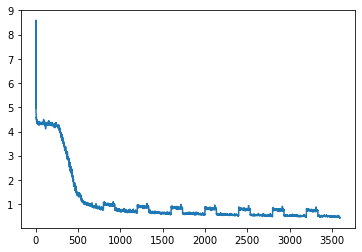

In [ ]:
plt.plot(loss[:])

In [ ]:
# Save a dictionary into a pickle file.
import pickle
pickle.dump( loss, open( "/content/drive/MyDrive/gae_loss/save" + str(EXPERIMENTAL_ID) + ".p", "wb" ) )

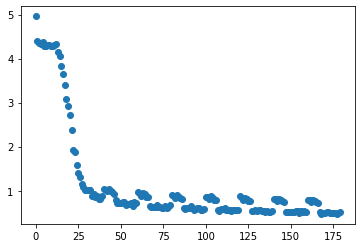

In [ ]:
plt.plot(loss[::BATCH_SIZE],'o')

# **Continue Training**

In [ ]:
# If you are using continue training, please re-define an auto-encoder
def define_autoencoder(input_shape,
                       e_layer_sizes, 
                       e_filter_sizes, 
                       e_num_filters,
                       g_layer_sizes,
                       g_filter_sizes,
                       g_num_filters):
    
  e_iterations = len(e_layer_sizes)
  g_iterations = len(g_layer_sizes)

  # Encoder Section
  input_layer = Input(shape = input_shape)
  for i in range(e_iterations):
      if (i != 0):
          x = Conv2D(e_num_filters[i], kernel_size=(e_filter_sizes[i], e_filter_sizes[i]), strides=(2,2), padding='same')(x)
      else:
          x = Conv2D(e_num_filters[i], kernel_size=(e_filter_sizes[i], e_filter_sizes[i]), strides=(1,1), padding='same')(input_layer)
      x = BatchNormalization()(x)
      x = LeakyReLU(alpha=0.2)(x)

  
  # Ganerative Section
  for i in range(g_iterations):
      x = Conv2DTranspose(filters = g_num_filters[i], 
                          kernel_size = (g_filter_sizes[i], g_filter_sizes[i]), 
                          strides = (2, 2), 
                          padding = 'same')(x)
      x = BatchNormalization()(x)
      x = ReLU()(x)
  
  x = Conv2DTranspose(1, kernel_size=(1, 1), padding='same')(x)
  output_layer = tf.keras.activations.sigmoid(x)

  model = Model(input_layer, output_layer)
  
  return model

In [ ]:
model = define_autoencoder(input_shape = INPUT_SHAPE,
                          e_layer_sizes = E_LAYER_SIZES,
                          e_filter_sizes = E_FILTER_SIZES,
                          e_num_filters = E_NUM_FILTERS,
                          g_layer_sizes = G_LAYER_SIZES,
                          g_filter_sizes = G_FILTER_SIZES,
                          g_num_filters = G_NUM_FILTERS)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 320, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 320, 256, 1)       170       
_________________________________________________________________
batch_normalization (BatchNo (None, 320, 256, 1)       4         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 320, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 160, 128, 128)     15616     
_________________________________________________________________
batch_normalization_1 (Batch (None, 160, 128, 128)     512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 160, 128, 128)     0     

In [ ]:
MODEL_LOAD_PATH = '/content/drive/MyDrive/gae_weights/'
OPTIMIZER_LOAD_PATH = '/content/drive/MyDrive/gae_opt/'

In [ ]:
model_weights_file_name = 'gae_id6_epoch9'
opt_weights_file_name = 'gae_id6_epoch9'

# Get saved weights
opt_weights = np.load(OPTIMIZER_LOAD_PATH + opt_weights_file_name + '.npy', allow_pickle=True)
# Get Model Weights 
model_weights = np.load(MODEL_LOAD_PATH + model_weights_file_name + '.npy', allow_pickle=True)

In [ ]:
loss, _,_,_ = train(model, 
                    train_df.train, 
                    train_df.train_target, 
                    BATCH_SIZE, 
                    EPOCH, 
                    EXPERIMENTAL_ID + 1000, 
                    is_continue = True, 
                    model_weights = model_weights, 
                    opt_weights = opt_weights)

Continue Training...
Epoch : 1 / 21
Training Progression |****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************|
Time used: 2:28:43.575325
Minimum loss: 1000000.0
Loss: 0.559506957972312
Save weights of epoch: 1


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Epoch : 2 / 21
Training Progression |****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************|
Time used: 0:10:04.988123
Minimum loss: 0.559506957972312
Loss: 0.5395175581097127
Save weights of epoch: 2
Epoch : 3 / 21
Training Progression |****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************|
Time used: 0:1

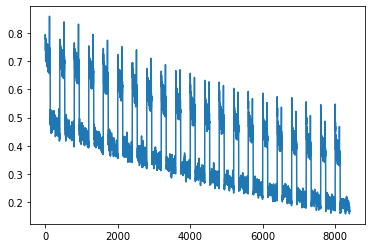

In [ ]:
plt.plot(loss[:])

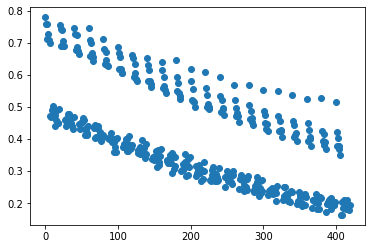

In [ ]:
plt.plot(loss[::BATCH_SIZE], 'o')

# **Prediction from Loaded Model**

In [ ]:
  # Define Optimizer
  optimizers = Adam(learning_rate=LR, beta_1=MOMENTUM, decay=WEIGHT_DECAY, epsilon=EPSILON)

  grad_vars = model.trainable_weights
  zero_grads = [tf.zeros_like(w) for w in grad_vars]
  optimizers.apply_gradients(zip(zero_grads, grad_vars))

  optimizers.set_weights(opt_weights)
  model.set_weights(model_weights)
  
  del zero_grads
  del grad_vars

In [ ]:
REAL_WORLD_SAMPLE_PATH = "/content/drive/MyDrive/RealFingerResized/"
real_world_path_list = [f for f in glob.glob(REAL_WORLD_SAMPLE_PATH + '*')]
real_world_path_list.sort()
print(real_world_path_list[29:33])
print(len(real_world_path_list))

['/content/drive/MyDrive/RealFingerResized/5.jpg', '/content/drive/MyDrive/RealFingerResized/6.jpg', '/content/drive/MyDrive/RealFingerResized/7.jpg', '/content/drive/MyDrive/RealFingerResized/8.jpg']
34


In [ ]:
start_num = 0
stop_num = 33

In [ ]:
tester = tf.convert_to_tensor(get_image_batch(real_world_path_list[start_num: stop_num], thresholding=True))
tester = tf.reshape(tester, (-1, 320, 256, 1))
tester_y = tf.convert_to_tensor(get_image_batch(real_world_path_list[start_num: stop_num], thresholding=True))
tester_y = tf.reshape(tester_y, (-1, 320, 256, 1))
pred = model.predict(tester)

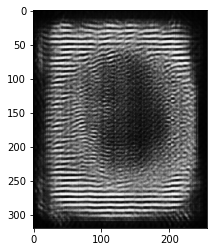

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


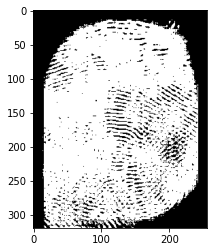

In [ ]:
plt.imshow(pred[0].reshape(320, 256), 'gray')
plt.show()
(thresh, blackAndWhiteImage) = cv2.threshold(pred[2].reshape(320, 256), 1e-1, 1, cv2.THRESH_BINARY)
print(blackAndWhiteImage)
plt.imshow(blackAndWhiteImage, 'gray')
plt.show()

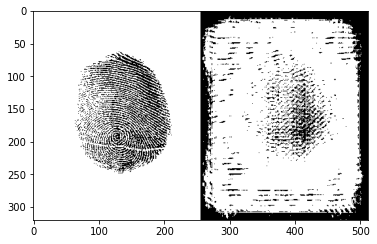

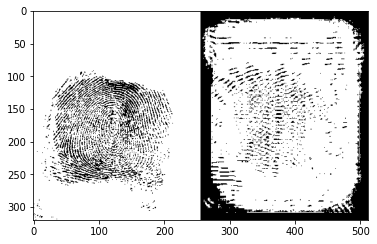

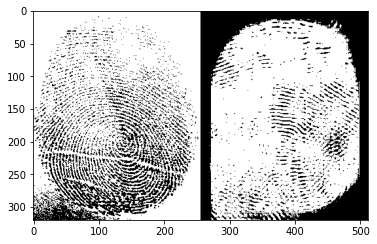

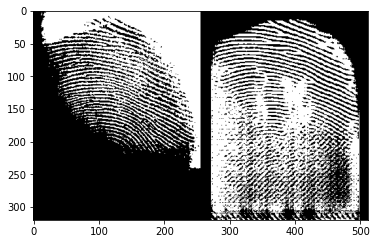

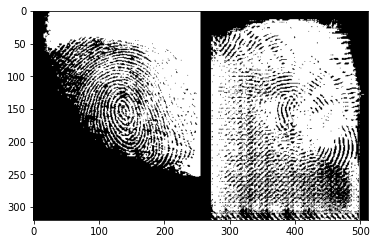

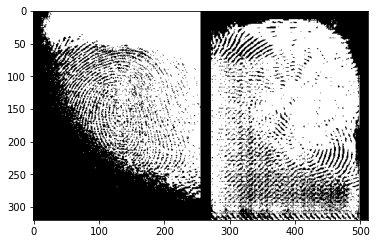

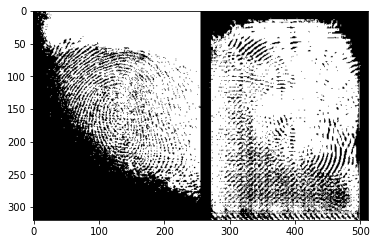

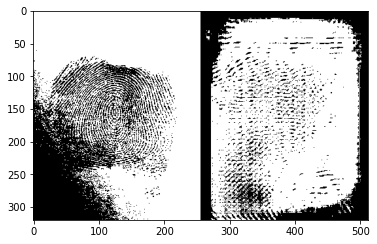

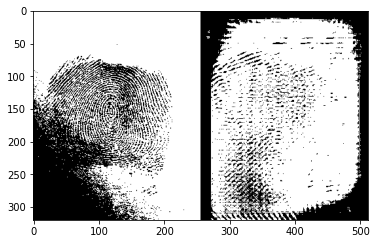

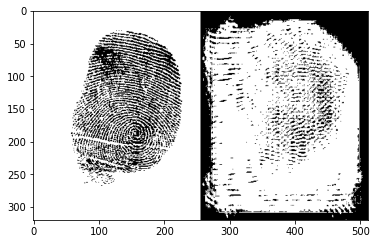

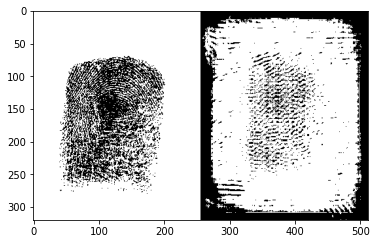

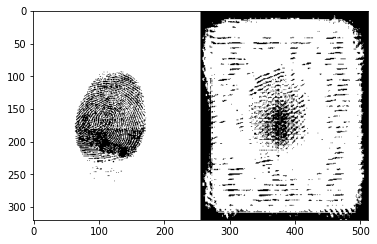

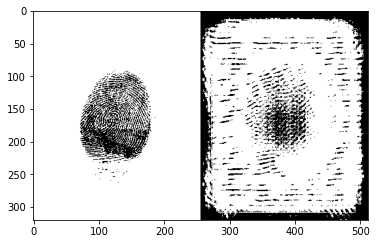

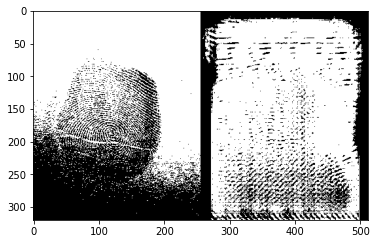

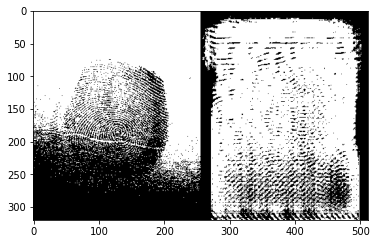

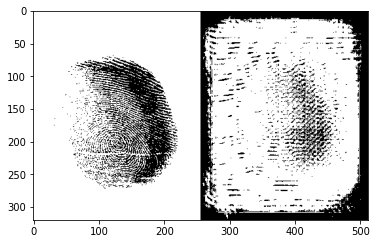

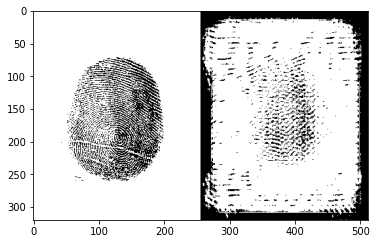

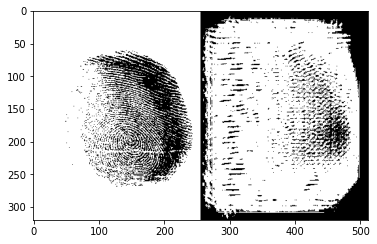

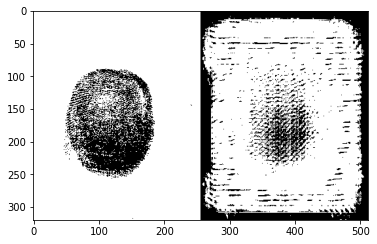

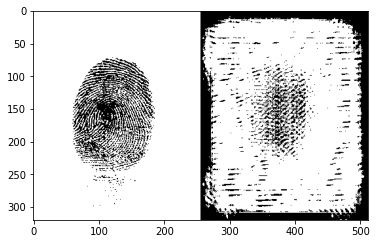

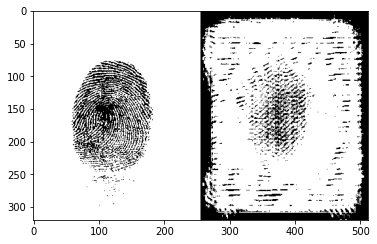

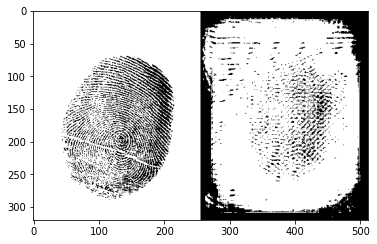

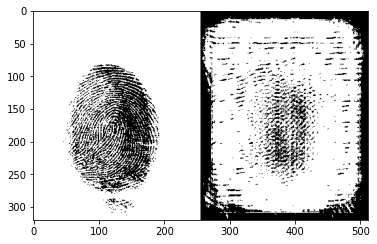

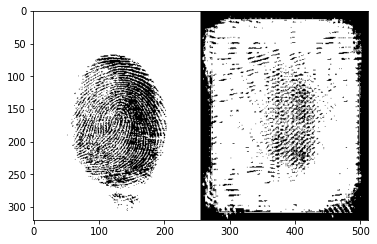

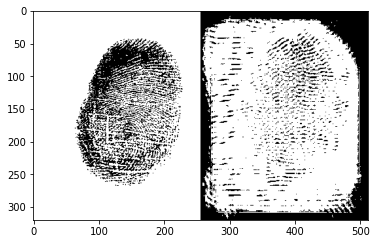

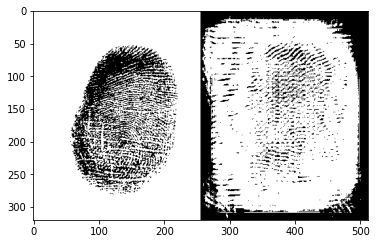

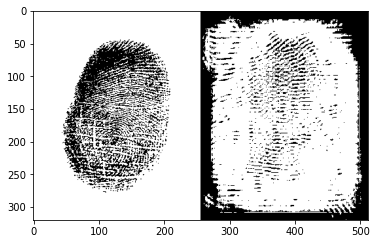

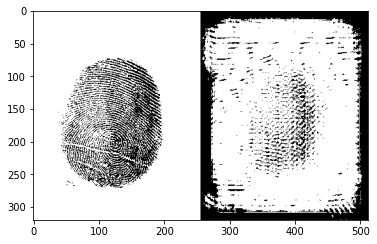

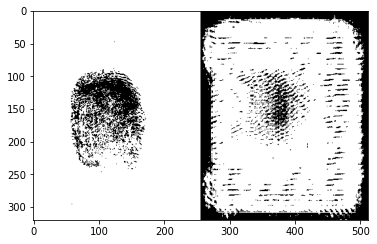

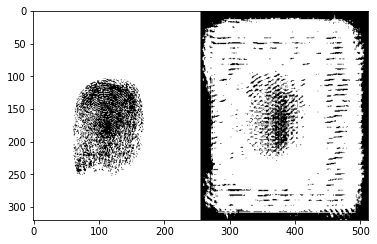

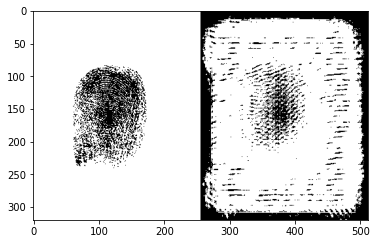

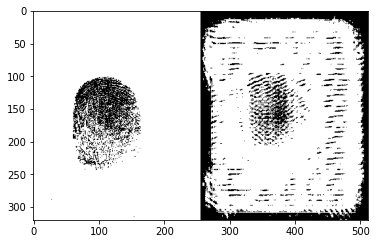

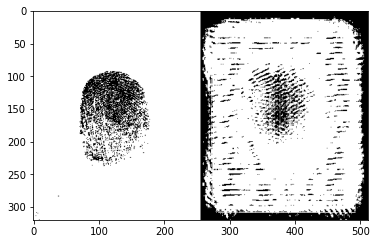

In [ ]:
# Save prediction images to google drive
PREDICT_SAVE_PATH = '/content/drive/MyDrive/gae_prediction_result/'

for i in range(len(pred)):
  (thresh, x) = cv2.threshold(tester[i].numpy().reshape(320, 256), 0.5, 255, cv2.THRESH_BINARY)
  (thresh, y) = cv2.threshold(pred[i].reshape(320, 256), 1e-1, 255, cv2.THRESH_BINARY)
  # (thresh, z) = cv2.threshold(tester_y[i].numpy().reshape(320, 256), 0.5, 255, cv2.THRESH_BINARY)

  # print(x)
  # print(y)
  # print(z)

  concat_img = np.hstack((x, y))
  # concat_img = cv2.hconcat([x, y, z])
  # print(concat_img.shape)
  # cv2.imwrite(PREDICT_SAVE_PATH + 'result_' + str(i) + '.png', concat_img)
  
  # Show the output image 
  plt.imshow(concat_img, 'gray')
  plt.show()

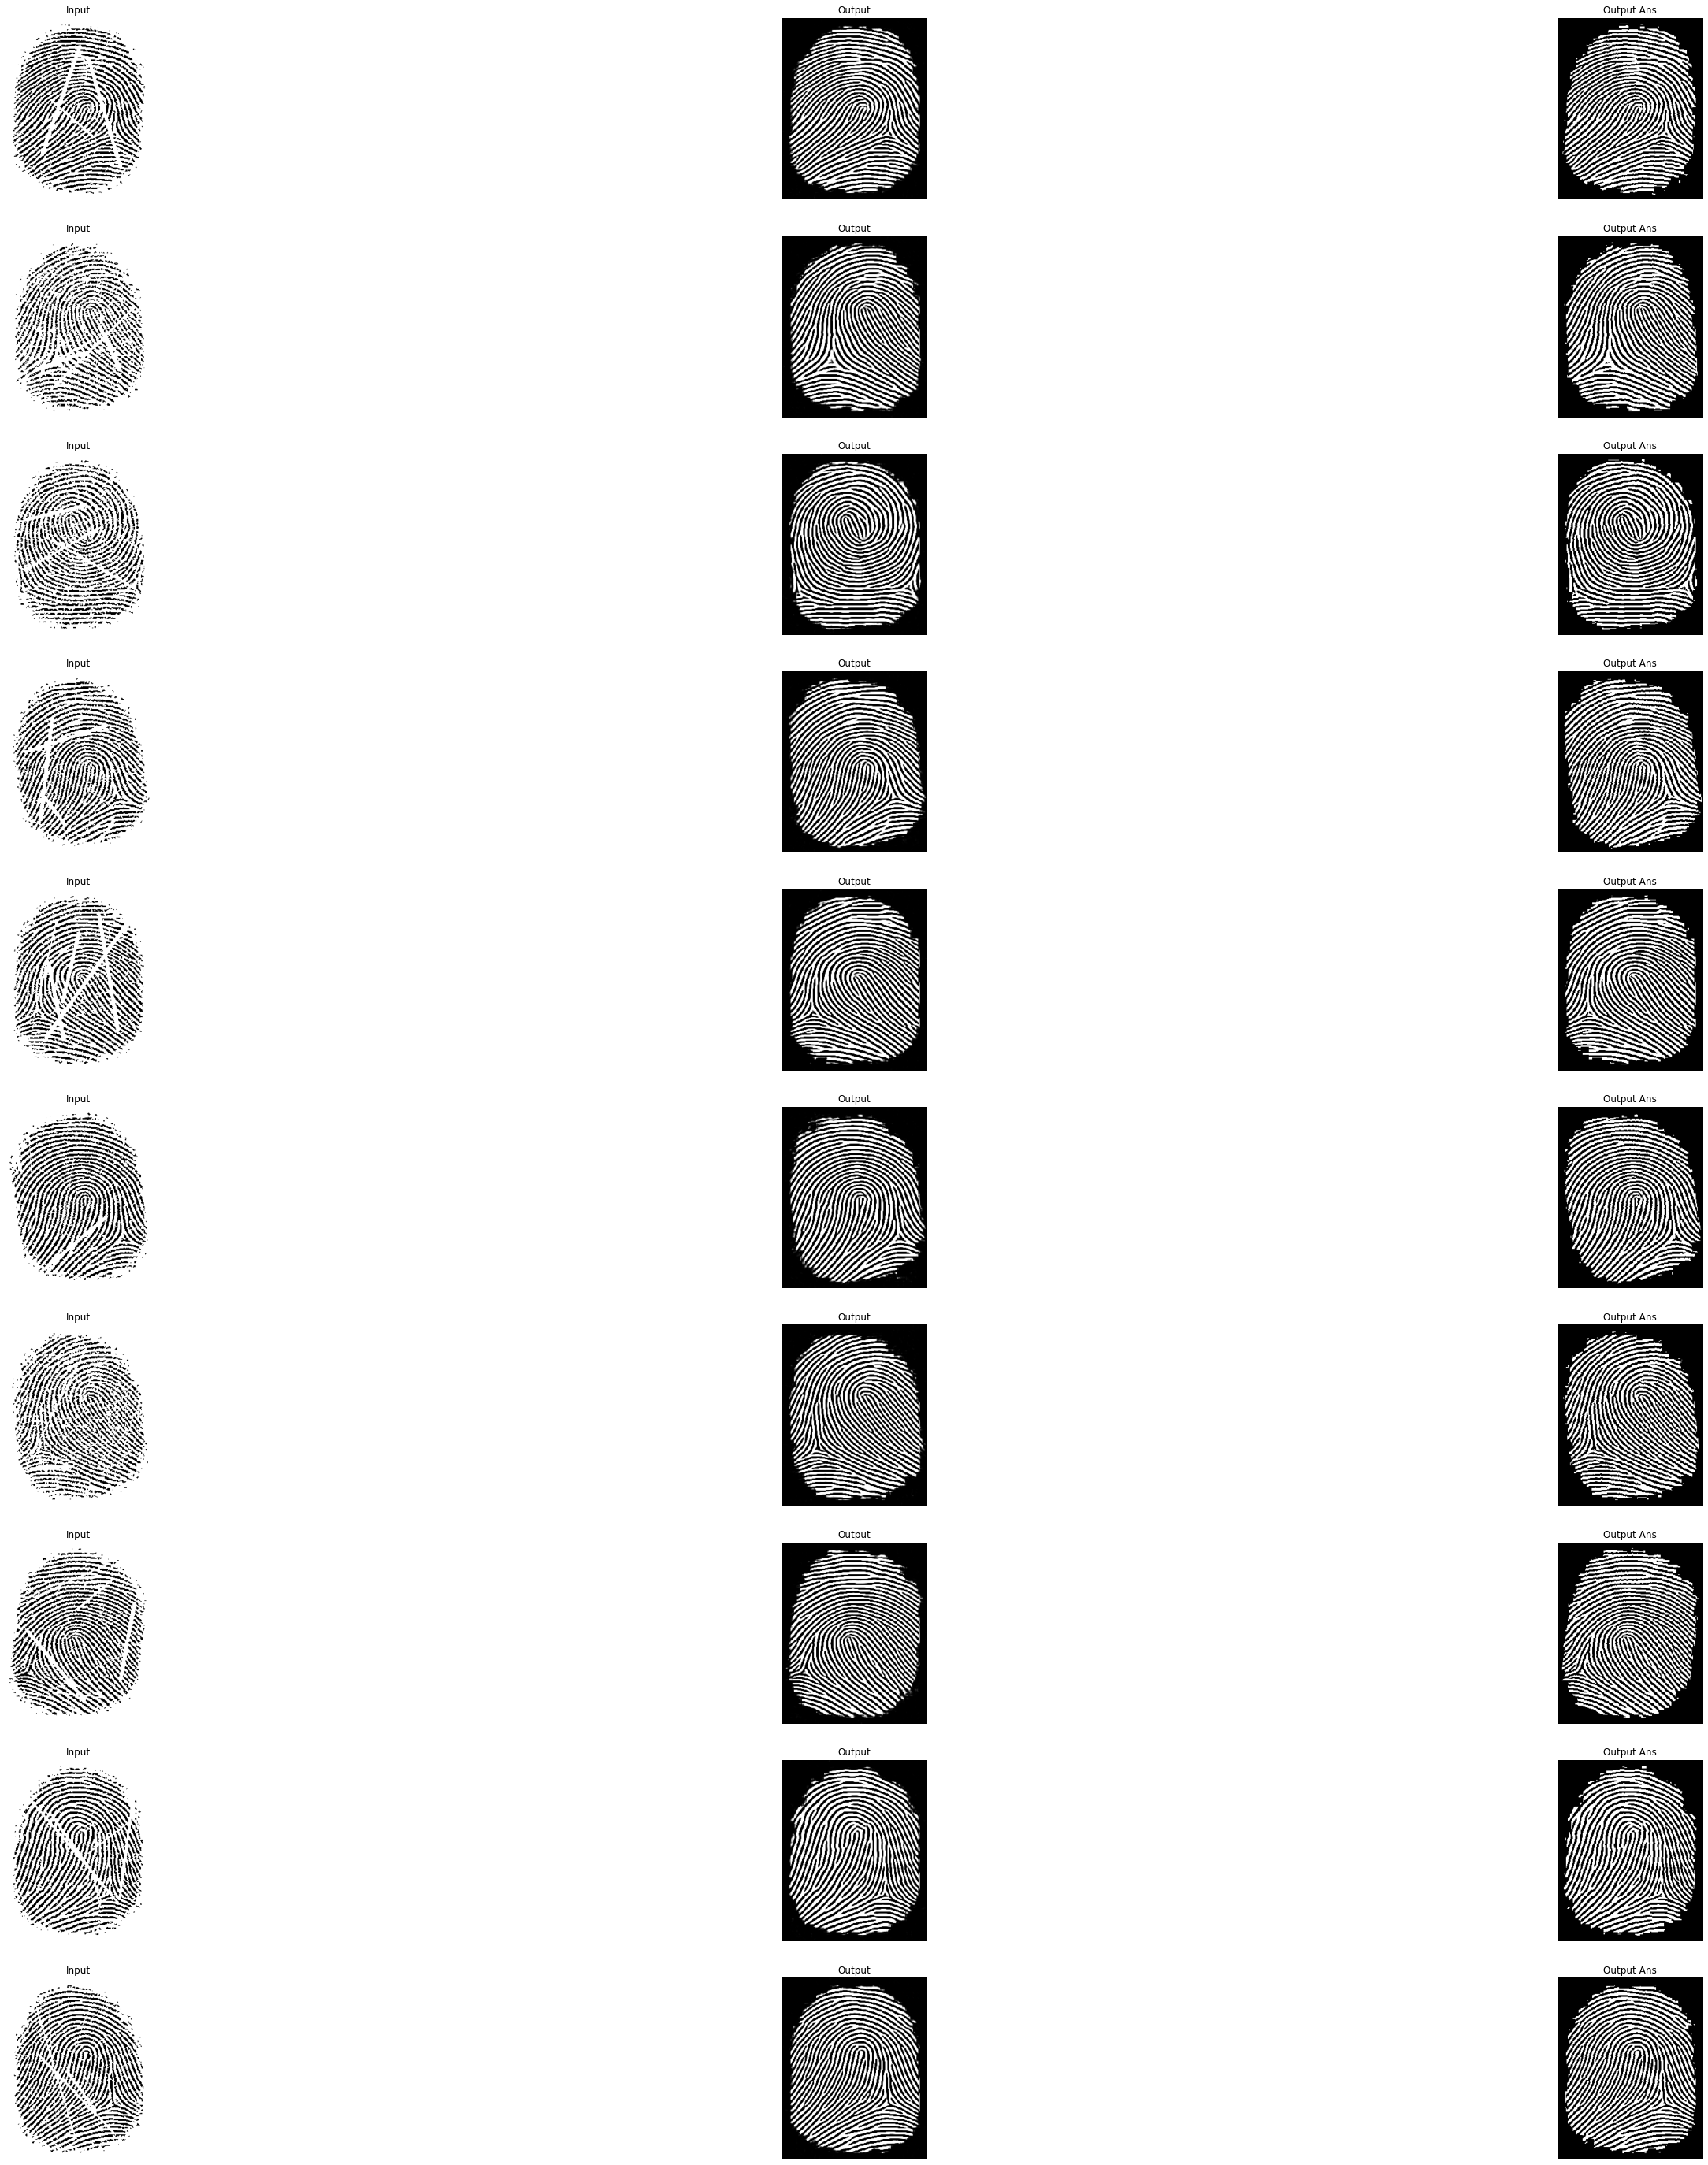

In [ ]:
f, axarr = plt.subplots(len(pred), 3, figsize=(50,50))

for i in range(len(pred)):
  axarr[i,0].imshow(tester[i].numpy().reshape(320, 256), cmap = 'gray')
  axarr[i,0].set_title("Input")
  axarr[i,0].axis('off')
  axarr[i,1].imshow(pred[i].reshape(320, 256), cmap = 'gray')
  axarr[i,1].set_title("Output")
  axarr[i,1].axis('off')
  axarr[i,2].imshow(tester_y[i].numpy().reshape(320, 256), cmap = 'gray')
  axarr[i,2].set_title("Output Ans")
  axarr[i,2].axis('off')
  # axarr[i,3].imshow(tester_y[i].numpy().reshape(320, 256) - pred[i].reshape(320, 256), cmap = 'gray')
  # axarr[i,3].set_title("Output Ans Diff")
  # axarr[i,3].axis('off')
plt.show()

# **Model Evaluation**

In [ ]:
def evaluate(test_paths, batch_size):
  if ((len(test_paths.test) % batch_size) != 0):
    print('batch_size is invalid, because there is not divisible')
    return

  batch_round = math.ceil(len(test_paths.test) / batch_size)
  test_loss = []
  for batch in range(batch_round):
    # Calculate starting and ending of batch
    batch_start = batch * batch_size
    batch_end = (batch_start + batch_size)
    print('Round:', str(batch + 1), '/', str(batch_round))
    print('Image range:', str(batch_start) + ':' + str(batch_end))

    # Slice paths in range of starting and ending of batch
    test_x_path = test_paths.test[batch_start:batch_end]
    test_target_path = test_paths.test_target[batch_start:batch_end]

    # Fetch images and perform thresholding
    test_x = get_image_batch(test_x_path, thresholding=True)
    test_target = get_image_batch(test_target_path, thresholding=True)

    # Convert testing image to tensorflow
    test_x_tf = tf.convert_to_tensor(test_x)
    test_x_tf = tf.round(tf.reshape(test_x_tf, (-1, 320, 256, 1)))
    test_target_tf = tf.convert_to_tensor(test_target)
    test_target_tf = tf.round(tf.reshape(test_target_tf, (-1, 320, 256, 1)))

    # Prediction from model
    pred = model.predict(test_x_tf)

    # Calculate loss between prediction result and test_target
    loss = loss_fn_tf(test_target_tf, pred)
    batch_loss = sum(loss.numpy()) / len(loss.numpy())
    test_loss.append(batch_loss)

    print('Batch loss:', str(batch_loss))
  return test_loss

In [ ]:
test_loss = evaluate(test_df, 20)

Round: 1 / 100
Image range: 0:20
Batch loss: 0.6470672698748703
Round: 2 / 100
Image range: 20:40
Batch loss: 0.6379989538482005
Round: 3 / 100
Image range: 40:60
Batch loss: 0.652609819406627
Round: 4 / 100
Image range: 60:80
Batch loss: 0.6652328092307471
Round: 5 / 100
Image range: 80:100
Batch loss: 0.6625316206450399
Round: 6 / 100
Image range: 100:120
Batch loss: 0.6610887314282597
Round: 7 / 100
Image range: 120:140
Batch loss: 0.6612024179059953
Round: 8 / 100
Image range: 140:160
Batch loss: 0.6793618413179496
Round: 9 / 100
Image range: 160:180
Batch loss: 0.6476072528729927
Round: 10 / 100
Image range: 180:200
Batch loss: 0.6498195221585978
Round: 11 / 100
Image range: 200:220
Batch loss: 0.6473567737433381
Round: 12 / 100
Image range: 220:240
Batch loss: 0.6734572629259434
Round: 13 / 100
Image range: 240:260
Batch loss: 0.6488242962107365
Round: 14 / 100
Image range: 260:280
Batch loss: 0.6522398097768977
Round: 15 / 100
Image range: 280:300
Batch loss: 0.6629325197434212


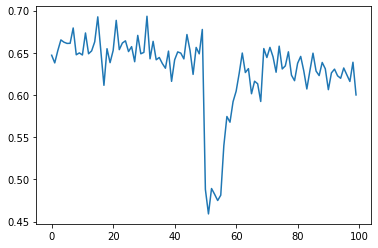

In [ ]:
plt.plot(test_loss)

In [ ]:
image_batch = get_image_batch(test_df.test[0:11], thresholding=True)
image_batch_tf = tf.convert_to_tensor(image_batch)
batch = tf.reshape(image_batch_tf, (-1, 320, 256))
pred_batch = model.predict(batch)

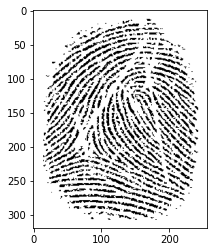

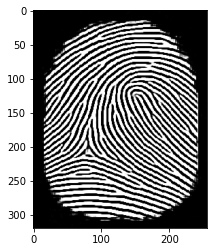

In [ ]:
plt.imshow(image_batch[5].reshape(320, 256), 'gray')
plt.show()
plt.imshow(pred_batch[5].reshape(320, 256) * 1e3, 'gray')
plt.show()

In [ ]:
cv2.imwrite(PREDICT_SAVE_PATH + 'pred_result_' + '1'+ '.png', pred_batch[0].reshape(320, 256) * 1e3)

True

In [ ]:
def save_prediction_image(test_paths, batch_size, model, save_original=False):
  if ((len(test_paths.test) % batch_size) != 0):
    print('batch_size is invalid, because there is not divisible')
    return

  batch_round = math.ceil(len(test_paths.test) / batch_size)
  for batch in range(batch_round):
    batch_start = batch * batch_size
    batch_end = (batch_start + batch_size)

    test_x_path = test_paths.test[batch_start:batch_end]
    # print(test_x_path)
    # Fetch images and perform thresholding
    test_x = get_image_batch(test_x_path, thresholding=True)

    image_batch_tf = tf.convert_to_tensor(test_x)
    batch = tf.reshape(image_batch_tf, (-1, 320, 256))
    pred_batch = model.predict(batch)

    for i, pred_img in enumerate(pred_batch):
      file_name = test_x_path[i + batch_start].split('/')[-1]
      # print(file_name)
      if (save_original):
        path = '/content/drive/MyDrive/test_noise_reshaped/'
        original_reshaped_img = test_x[i].reshape(320, 256) * 255
        cv2.imwrite(path + file_name, original_reshaped_img)
      reshaped_img = pred_img.reshape(320, 256)
      cv2.imwrite(PREDICT_SAVE_PATH + file_name, reshaped_img * 1e3)

In [ ]:
save_prediction_image(test_df, 20, model, True)

In [ ]:
result_path = [f for f in glob.glob(PREDICT_SAVE_PATH + '*.png')]
print(len(result_path))

2000


In [ ]:
- บอก scope งานเราให้ชัดเจน
limit 2 เรื่อง 
1. Binarization ทำงานได้ไม่ดี >> intensity ของ feature ใกล้เคียงกับ noise, อาจจะเปลี่ยนวิธี เป็นใช้โมเดล 
2. Background noise มีผลต่อโมเดลอย่างชัดเจน ควรจะลบ background noise ก่อนทำการ Enhanc

normality,
Wilcoxon signed-rank test,
ลองนิ้วจริง
ทำเล่มดำบทที่ 3 - 
  - Overview of program (Block architecture)
  - 3.2 Preprocess (Binarization)
  - 3.3 GAE in detail (Binarize, Loss, Architecture)
บทที่ 4 ผลการทดลอง
  - Data ที่เอามาใช้มีไรบ้าง มีกี่รูป โปรเเกรมที่สร้างรูปขึ้นมา ลักษณะของภาพที่ได้จากโปรเเกรม (process ในการสร้างรูป)
  - NFIQ Before and after
  - Statistical Test

บทที่ 5 Further suggestion
 - เกี่ยวกับการใช้ mathcing ในการ evaluate
 - Limitaion -> Binarization, Background noise ที่จะดีกว่ามั้ยที่อาจจะใช้เป็นโมเดลอีกตัวในการช่วย preprocess หรืออาจจะเลือก image pro algo ที่ดีกว่านี้
 - ศึกษาการ resize ว่ามันส่งผลต่อ Quality score ยังไงบ้าง , upsampling ตอนก่อนเข้า nfiq มีปัญหารึเปล่า 
 - เพิ่ม indicatorตอน evaluate
( Mention ถึงปัญหา, challenges ที่เกิดขึ้นกับ real samples)
บทที่ 6 - Conclusion

Appendix refer to Github repo
References
